In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import sklearn.cluster
import sklearn
import scipy
import PIL.Image
import multiprocessing

large_width = 400
np.set_printoptions(linewidth=large_width)

In [2]:
# Calculate Jclust for the passed dataset
def jclust(dataset, reps, c):
    jclust = 0.0
    v = np.zeros(8, dtype=np.float64)
    for i in range(0, dataset.shape[0]):
        v = dataset[i,:] - reps[c[i],:]
        jclust += np.linalg.norm(v)**2
    jclust /= dataset.shape[0]
    return jclust

In [3]:
# Run K-means algorithm on data vector with k cluster, return 1-d vector of representative assignments and 2-d vector of representatives
def image_kmeans(data, k, max_iterations, tolerance=0.05, update_interval=0):
    cluster_assignments = np.zeros(data.shape[0], dtype = np.int8)
    cluster_counts = np.zeros(k, dtype=np.int64)
    representatives = np.random.randint(255, size=(k,3), dtype=np.uint8)
    Jclust = np.inf

    iterations = 0
    sufficient_descent = True
    jclust_prev = np.inf
    v = np.zeros(3, dtype=np.float64)
    v_sum = np.zeros(3, dtype=np.float64)
    v_mean = np.zeros(3, dtype=np.float64)
    if update_interval > 0: print("Iterations completed: ", end='')
    while iterations < max_iterations and sufficient_descent:
        iterations += 1
        cluster_counts[:] = 0
        #Assign data to cluster of nearest representative
        for i in range(0, data.shape[0]):
            dmin = 10000.0
            d = 10000.0
            v[:] = 0
            index = -1
            for j in range(0, representatives.shape[0]):
                v = data[i,:] - representatives[j,:]
                d = np.linalg.norm(v)
                if d < dmin:
                    index = j
                    dmin = d
                    cluster_assignments[i] = j
                if j == representatives.shape[0] - 1: cluster_counts[index] += 1
        
        # Recalculation of cluster centroids
        for i in range(0, representatives.shape[0]):
            v_sum[:] = 0.0
            v_mean[:] = 0.0
            for j in range(0, data.shape[0]):
                if cluster_assignments[j] == i: 
                    v_sum += data[j,:]
            v_mean = v_sum / cluster_counts[i]
            representatives[i,:] = v_mean.astype(np.int8)
        
        # Recalculate Jclust, update descent variable if level of improvement is below tolerance threshhold
        jclust_prev = Jclust
        Jclust = jclust(data, representatives, cluster_assignments)
        if Jclust/jclust_prev >= 1-tolerance:
            sufficient_descent = False
        
        if update_interval > 0 and iterations % update_interval == 0:
            print(f"{iterations}, ", end="")
    
    # Clip representative vectors if needed
    representatives = np.clip(representatives.astype('uint8'), 0, 255)

    return cluster_assignments, representatives



#### MULTIPROCESSING ####

def calculate_distances(data_chunk, representatives):


# Run K-means algorithm on data vector with k cluster, return 1-d vector of representative assignments and 2-d vector of representatives
def image_kmeans(data, k, max_iterations, tolerance=0.05, update_interval=0):
    cluster_assignments = np.zeros(data.shape[0], dtype = np.int8)
    cluster_counts = np.zeros(k, dtype=np.int64)
    representatives = np.random.randint(255, size=(k,3), dtype=np.uint8)
    Jclust = np.inf

    ### Multiprocessing
    processors = 10

    iterations = 0
    sufficient_descent = True
    jclust_prev = np.inf
    v = np.zeros(3, dtype=np.float64)
    v_sum = np.zeros(3, dtype=np.float64)
    v_mean = np.zeros(3, dtype=np.float64)
    if update_interval > 0: print("Iterations completed: ", end='')

    while iterations < max_iterations and sufficient_descent:
        iterations += 1
        cluster_counts[:] = 0
        # Assign data to cluster of nearest representative
        ###pool1 = multiprocessing.Pool(processes = processors)
        for i in range(0, data.shape[0]):
            dmin = 10000.0
            d = 10000.0
            v[:] = 0
            index = -1
            for j in range(0, representatives.shape[0]):
                v = data[i,:] - representatives[j,:]
                d = np.linalg.norm(v)
                if d < dmin:
                    index = j
                    dmin = d
                    cluster_assignments[i] = j
                if j == representatives.shape[0] - 1: cluster_counts[index] += 1
        
        # Recalculation of cluster centroids
        for i in range(0, representatives.shape[0]):
            v_sum[:] = 0.0
            v_mean[:] = 0.0
            for j in range(0, data.shape[0]):
                if cluster_assignments[j] == i: 
                    v_sum += data[j,:]
            v_mean = v_sum / cluster_counts[i]
            representatives[i,:] = v_mean.astype(np.int8)
        
        # Recalculate Jclust, update descent variable if level of improvement is below tolerance threshhold
        jclust_prev = Jclust
        Jclust = jclust(data, representatives, cluster_assignments)
        if Jclust/jclust_prev >= 1-tolerance:
            sufficient_descent = False
        
        if update_interval > 0 and iterations % update_interval == 0:
            print(f"{iterations}, ", end="")
    
    # Clip representative vectors if needed
    representatives = np.clip(representatives.astype('uint8'), 0, 255)

    return cluster_assignments, representatives



In [4]:
# Convert compressed pixel data into viewable image
def unpack_kmeans(cluster_assignments, representatives, shape=(0,0)):
    unpacked = np.stack([np.zeros_like(cluster_assignments), np.zeros_like(cluster_assignments), np.zeros_like(cluster_assignments)], axis=-1)
    for i in range(0, cluster_assignments.size):
        unpacked[i,:] = representatives[cluster_assignments[i],:]
    if shape != (0,0):
        unpacked = unpacked.reshape(shape[0], shape[1], 3)
    unpacked = np.clip(unpacked.astype('uint8'), 0, 255)
    return unpacked


# K means (Mine)

# Read the image
img = PIL.Image.open('./images/raynie.jpeg')
img = np.array(img)

# Flatten pixels, maintain row order
img_vector = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

# Run manual Kmeans
k_clusters = 20
max_iterations = 3
pixel_clusters, colors = image_kmeans(img_vector, k_clusters, max_iterations, tolerance=0.001, update_interval=1)

# Decode result from cluster assignment vector and color list
unpacked_img = unpack_kmeans(pixel_clusters, colors, (img.shape[0], img.shape[1]))

# Calculate compression ratio
manual_kmeans_compression = img.size/(pixel_clusters.size + colors.size)
print(f"Compression: {manual_kmeans_compression}")

# Display
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(img)
ax[0].set_title('Original image')
ax[1].imshow(unpacked_img)
ax[1].set_title("Compressed image with " + str(k_clusters) + " colors")
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

In [11]:
# K means (sklearn)

# Read the image
img = PIL.Image.open('./images/fork.jpeg')
img = np.array(img)

# Flatten pixels, maintain row order
img_vector = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

# Run sklearn's Kmeans
k = 30
km = sklearn.cluster.KMeans(n_clusters=k, max_iter=100)
km.fit(img_vector)

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_]
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape color-compressed image into original dimensions
img_compressed = img_compressed.reshape(img.shape[0], img.shape[1], img.shape[2])


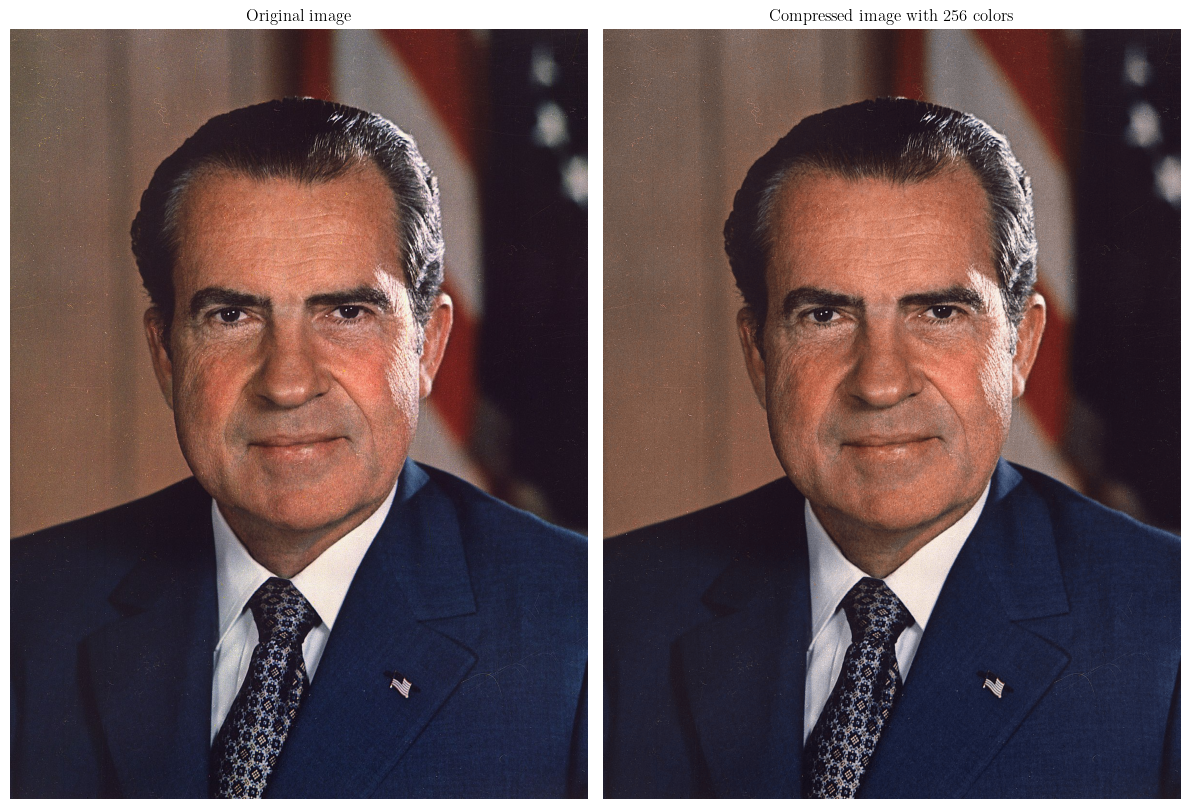

In [9]:

# Display
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})
fig, ax = plt.subplots(1, 2, figsize = (12, 10))
ax[0].imshow(img)
ax[0].set_title('Original image')
ax[1].imshow(img_compressed)
ax[1].set_title("Compressed image with " + str(k) + " colors")
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

(-0.5, 1199.5, 1598.5, -0.5)

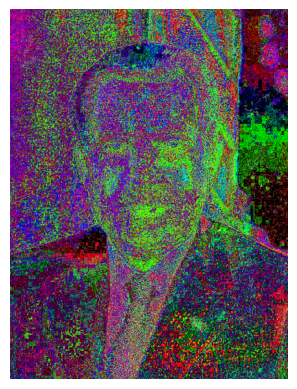

In [10]:
# Calculate difference
difference_image = np.abs(img - img_compressed)
diff_plot  = plt.imshow(difference_image)
diff_plot.axes.axis('off')

(1599, 1200, 3)


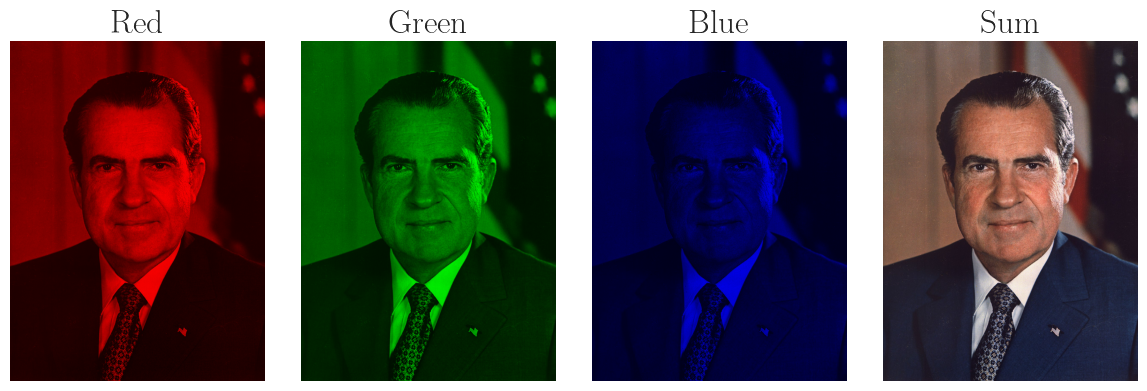

In [114]:
# Singular Value Decomposition 

# Open image, convert pixel color data to RGB if needed
im = PIL.Image.open("./images/nixon.jpeg")
im = im.convert(mode='RGB')

# Convert image to 3-dim array (height x width x color values), and separate by color
red = np.array(im)
green = np.array(im)
blue = np.array(im)
red[:,:,1:] = 0
green[:,:,[0,2]] = 0
blue[:,:,:2] = 0
print(red.shape)   #Print pixel dimensions of original image
# Display
plt.rcParams.update({"text.usetex": "True", "font.family": "Computer Modern Roman", "font.size": 24})
fig, ax = plt.subplots(1, 4, figsize = (12, 16))
ax[0].imshow(red)
ax[0].set_title('Red')
ax[1].imshow(green)
ax[1].set_title('Green')
ax[2].imshow(blue)
ax[2].set_title('Blue')
ax[3].imshow(im)
ax[3].set_title('Sum')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

In [80]:
# Return economy SVD matrices and error value given full SVD matrices
def svd_truncate(U, S, Vh, r):
    sortmap = np.flip(np.argsort(S))
    Sr = S[sortmap]
    Ur = U[:,sortmap]
    Vhr = Vh[sortmap,:]
    error = Sr[r+1]
    Sr = np.diag(Sr)
    Sr = Sr[0:r,0:r]
    Ur = Ur[:,0:r]
    Vhr = Vhr[0:r,:]
    return Ur, Sr, Vhr, error

# Return product of economy SVD matrices, clip out-of-bounds RGB values, and reform 3-dimensional array
def svd_product(U_r, S_r, Vh_r, index):
    A_r = U_r @ S_r @ Vh_r
    A_r = np.clip(A_r.astype('uint8'), 0, 255)
    #M = np.zeros((A_r.shape[0], A_r.shape[1], 3), dtype=np.int8)
    M = np.stack([np.zeros_like(A_r), np.zeros_like(A_r), np.zeros_like(A_r)], axis=-1)
    M[:,:,index] = A_r
    return M

Error [R, G, B]: [16815.44454588037, 16439.774630680007, 15989.450507524294]
Compression: 685.2857142857143


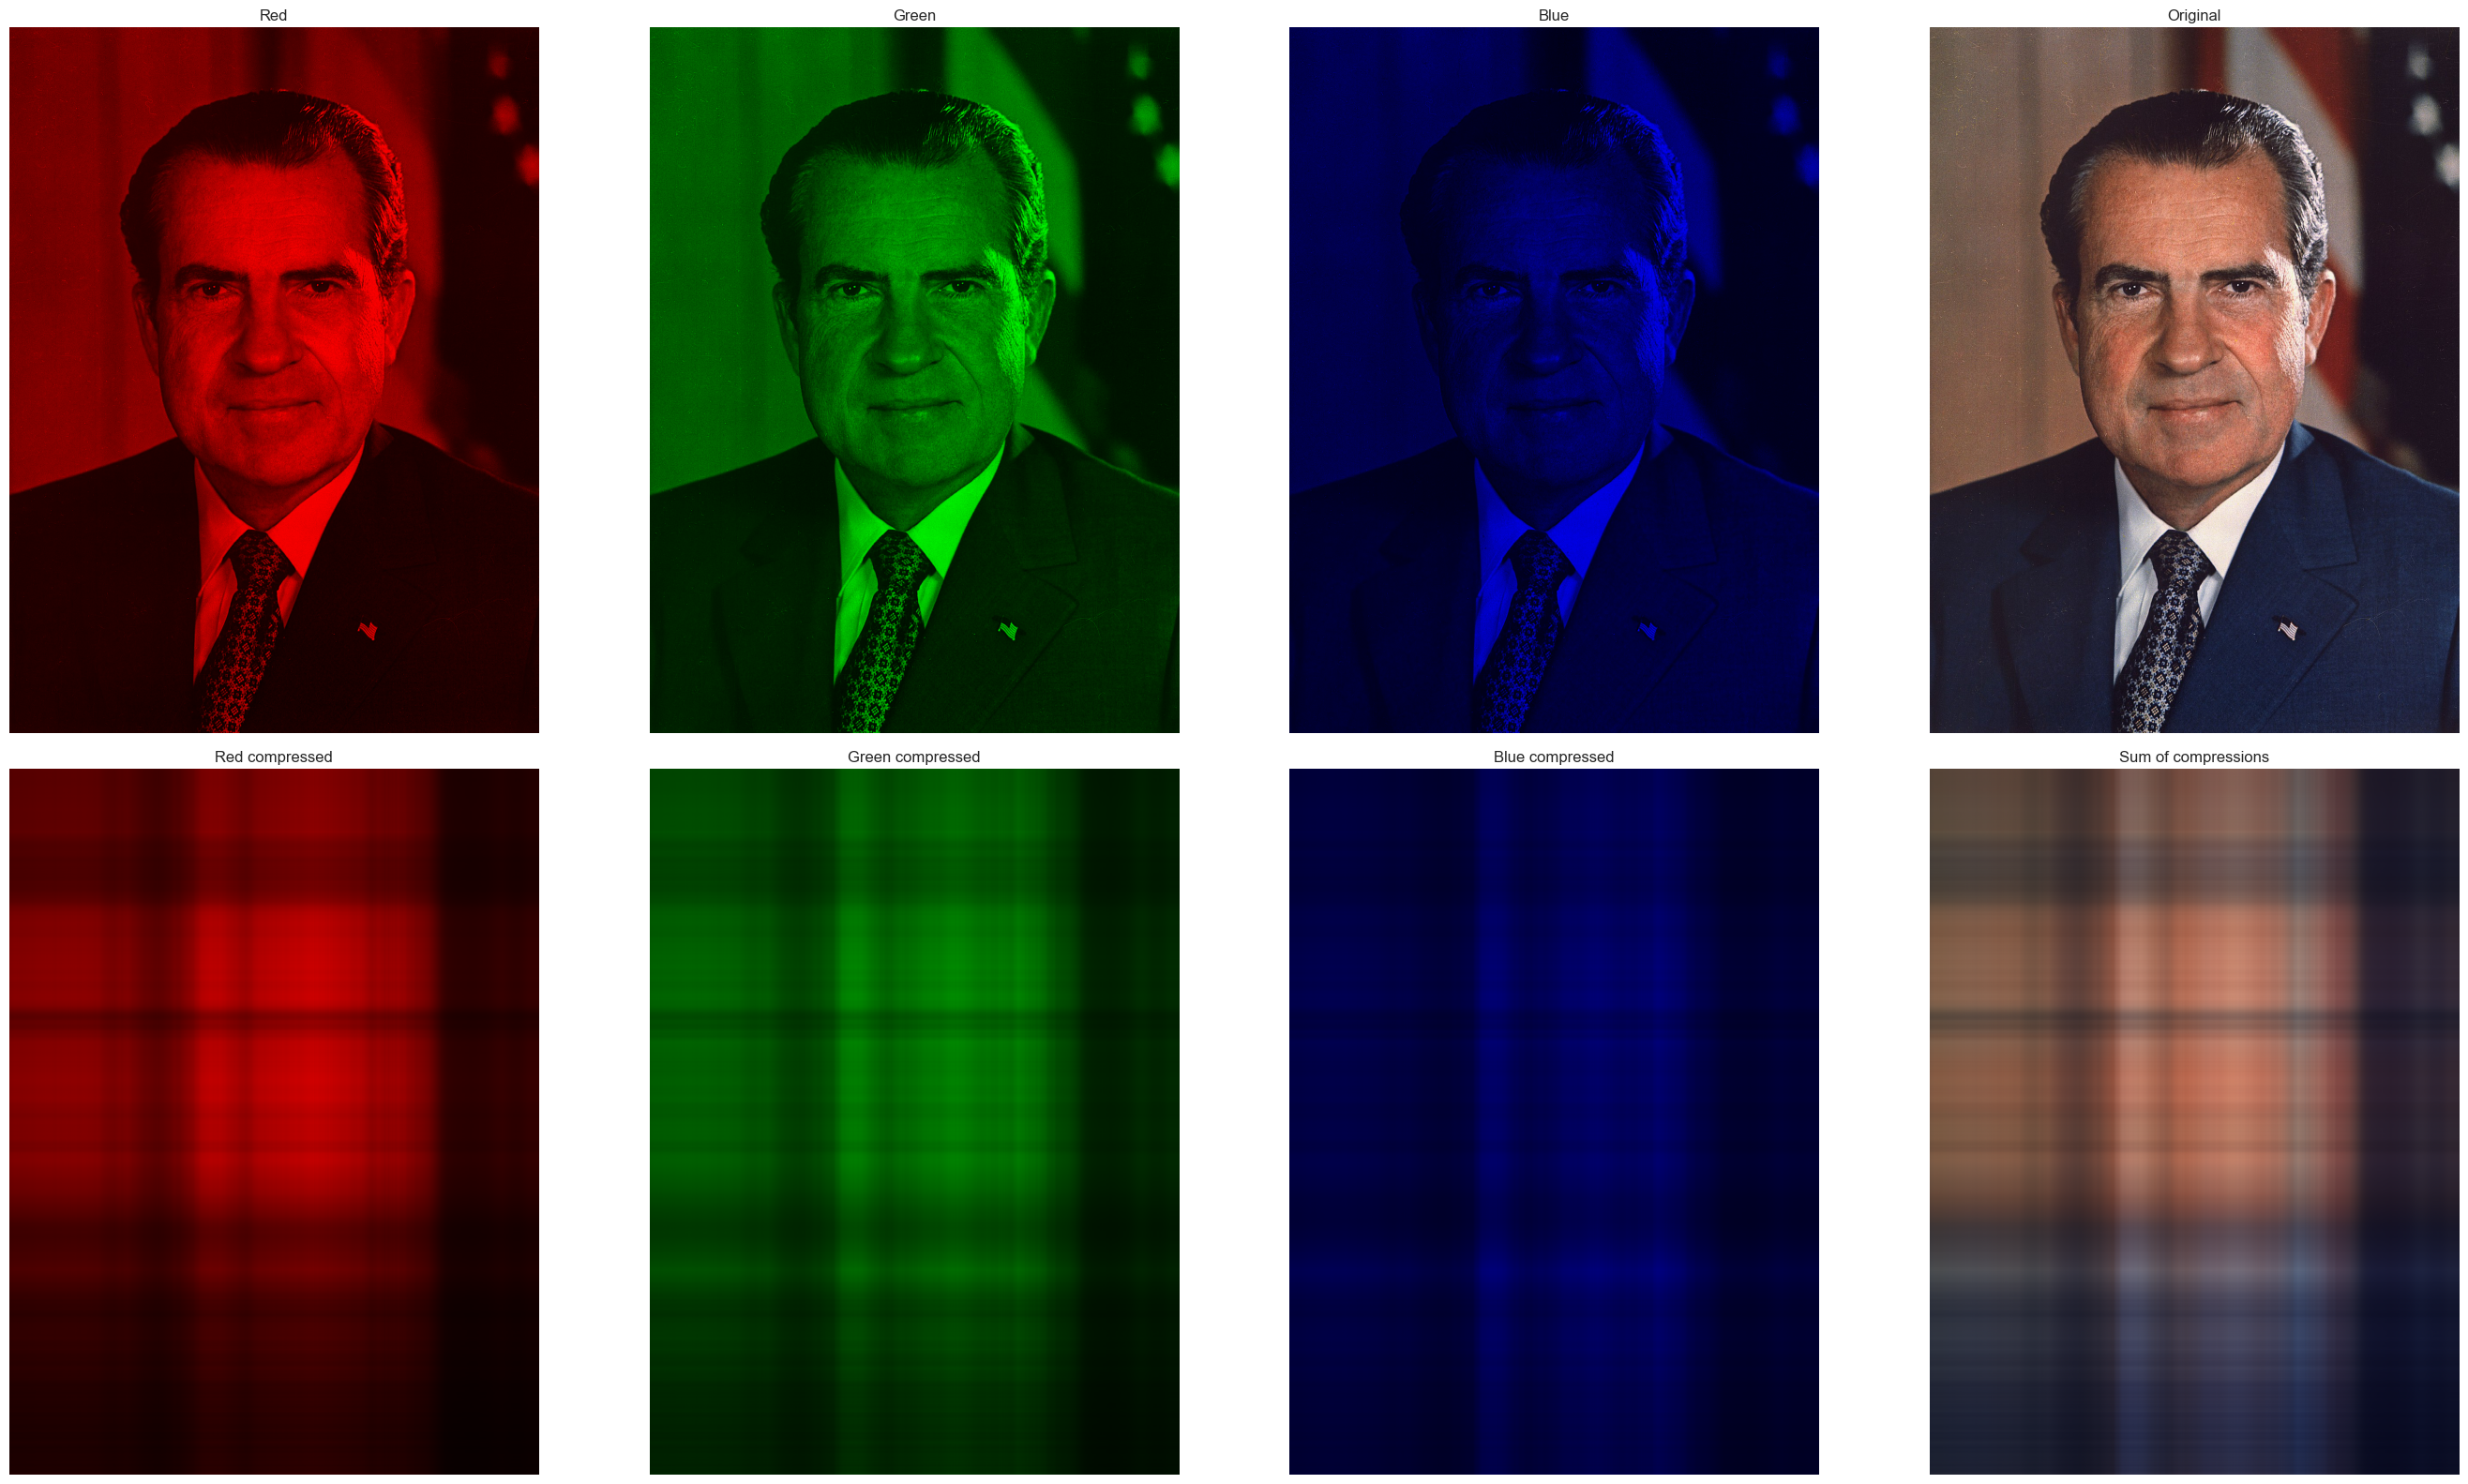

In [ ]:
# Split image array into RGB channels and perform color-wise SVD compression
red_split = red[:,:,0]
green_split = green[:,:,1]
blue_split = blue[:,:,2]

# Get SVD of red, green, and blue pixel color matrices
U_red, S_red, Vh_red = np.linalg.svd(red_split)
U_green, S_green, Vh_green = np.linalg.svd(green_split)
U_blue, S_blue, Vh_blue = np.linalg.svd(blue_split)

# Set r and compute economy SVD
r = 100
U_red_r, S_red_r, Vh_red_r, rederror = svd_truncate(U_red, S_red, Vh_red, r)
U_green_r, S_green_r, Vh_green_r, greenerror = svd_truncate(U_green, S_green, Vh_green, r)
U_blue_r, S_blue_r, Vh_blue_r, blueerror = svd_truncate(U_blue, S_blue, Vh_blue, r)

# Compute products of economy SVD matrices
red_r = svd_product(U_red_r, S_red_r, Vh_red_r, 0)
green_r = svd_product(U_green_r, S_green_r, Vh_green_r, 1)
blue_r = svd_product(U_blue_r, S_blue_r, Vh_blue_r, 2)

# Sum matrices into full 3-d pixel color matrix
sum_r = red_r + green_r + blue_r

# Calculate compression ratio
compression = img[:,:,0].size/(U_red_r.size + Vh_red_r.size + r)/3 + img[:,:,1].size/(U_green_r.size + Vh_green_r.size + r)/3 + img[:,:,2].size/(U_blue_r.size + Vh_blue_r.size + r)/3

#Display
print(f"Error [R, G, B]: {[rederror, greenerror, blueerror]}")
print(f"Compression: {compression}")
fig, ax = plt.subplots(2, 4, figsize = (28,16))
ax[0,0].imshow(red)
ax[0,0].set_title('Red')
ax[1,0].imshow(red_r)
ax[1,0].set_title('Red compressed')
ax[0,1].imshow(green)
ax[0,1].set_title('Green')
ax[1,1].imshow(green_r)
ax[1,1].set_title('Green compressed')
ax[0,2].imshow(blue)
ax[0,2].set_title('Blue')
ax[1,2].imshow(blue_r)
ax[1,2].set_title('Blue compressed')
ax[0,3].imshow(im)
ax[0,3].set_title('Original')
ax[1,3].imshow(sum_r)
ax[1,3].set_title('Sum of compressions')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

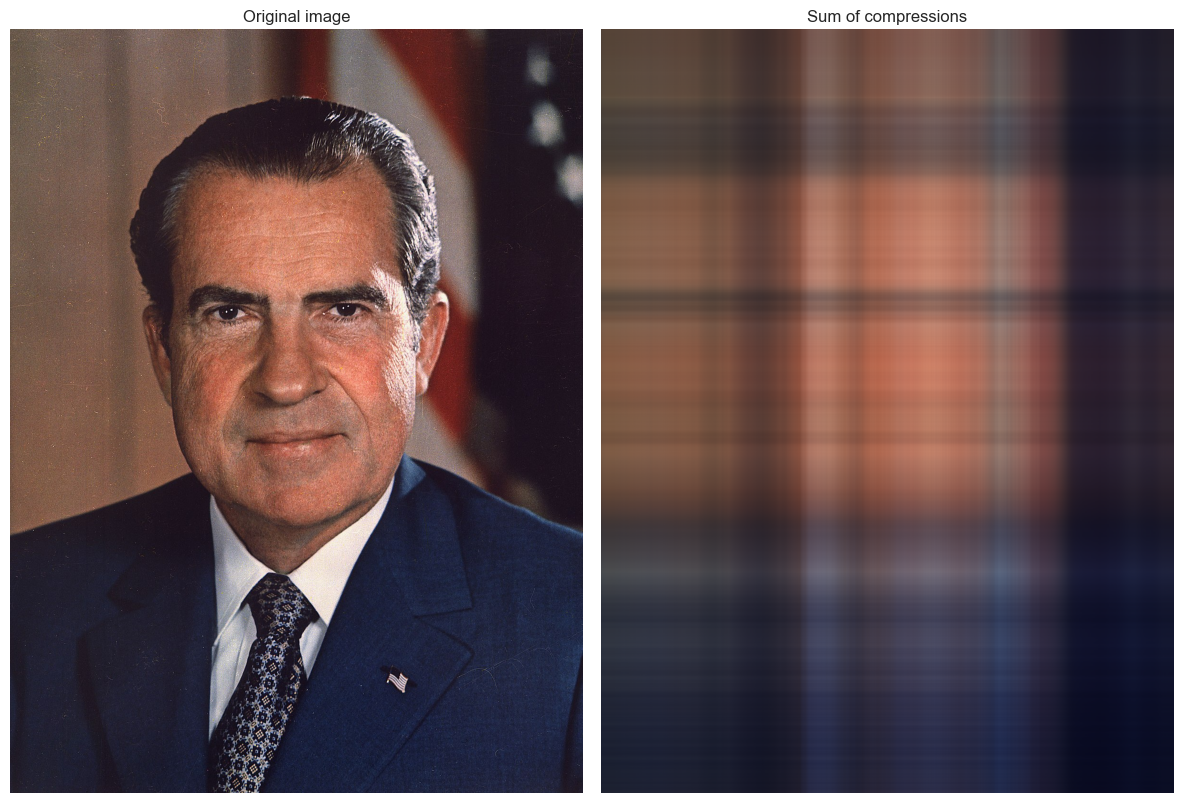

In [100]:
# Larger size view of before-and after for SVD compression
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(im)
ax[0].set_title('Original image')
ax[1].imshow(sum_r)
ax[1].set_title("Sum of compressions")
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

In [ ]:
# Calculate difference
difference_image = np.abs(im - sum_r)
diff_plot  = plt.imshow(difference_image)
diff_plot.axes.axis('off')